<font size=5>Convolutional Neural Networks: Application——卷积神经网络的应用

In [3]:
import math  # 导入math模块，提供数学函数和常数
import numpy as np  # 导入NumPy库，提供多维数组和数值计算工具
import h5py  # 导入h5py库，用于读写HDF5文件
import matplotlib.pyplot as plt  # 导入matplotlib库的pyplot模块，用于绘制图形
import scipy  # 导入SciPy库，提供科学计算功能
from PIL import Image  # 导入PIL库，用于处理图像
from scipy import ndimage  # 导入scipy库的ndimage模块，用于图像处理
import tensorflow as tf  # 导入TensorFlow库，用于构建和训练深度学习模型
from tensorflow.python.framework import ops  # 导入TensorFlow库的ops模块，用于操作计算图
from cnn_utils import *  # 导入自定义的cnn_utils模块，其中包含一些用于CNN的辅助函数和工具

# 配置matplotlib在Jupyter Notebook中进行图形渲染
%matplotlib inline  

np.random.seed(1)  # 设置随机种子，以确保随机数生成的结果可重现

tf.compat.v1.disable_eager_execution()  # 禁用TensorFlow的即时执行模式（Eager Execution）


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# 加载数据（手势数据集）
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


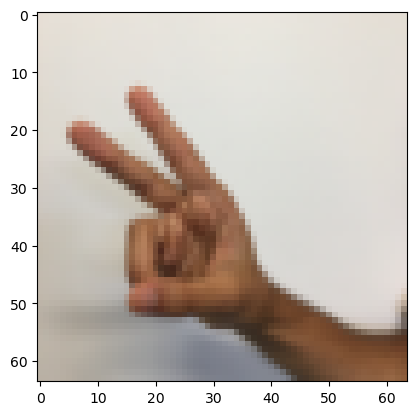

In [5]:
# 图片示例
index = 6  # 选择要展示的图片的索引
plt.imshow(X_train_orig[index])  # 使用plt.imshow显示选定索引的训练集中的图片
print("y = " + str(np.squeeze(Y_train_orig[:, index])))  # 打印该图片对应的标签值（将多维数组转换为标量）

In [6]:
# 对训练集和测试集进行归一化处理
X_train = X_train_orig / 255.  # 将训练集的像素值除以255，将像素值缩放到0到1之间
X_test = X_test_orig / 255.  # 将测试集的像素值除以255，将像素值缩放到0到1之间

# 将标签转换为独热编码形式
Y_train = convert_to_one_hot(Y_train_orig, 6).T  # 将训练集的标签转换为独热编码，并转置矩阵的维度
Y_test = convert_to_one_hot(Y_test_orig, 6).T  # 将测试集的标签转换为独热编码，并转置矩阵的维度

# 打印数据集信息
print("number of training examples = " + str(X_train.shape[0]))  # 打印训练集的样本数量
print("number of test examples = " + str(X_test.shape[0]))  # 打印测试集的样本数量
print("X_train shape: " + str(X_train.shape))  # 打印训练集的形状
print("Y_train shape: " + str(Y_train.shape))  # 打印训练集标签的形状
print("X_test shape: " + str(X_test.shape))  # 打印测试集的形状
print("Y_test shape: " + str(Y_test.shape))  # 打印测试集标签的形状

conv_layers = {}  # 初始化卷积层的字典

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    创建用于 TensorFlow 会话的占位符。
    
    参数：
    n_H0 -- 标量，输入图像的高度
    n_W0 -- 标量，输入图像的宽度
    n_C0 -- 标量，输入图像的通道数
    n_y -- 标量，类别的数量
        
    返回：
    X -- 用于数据输入的占位符，形状为 [None, n_H0, n_W0, n_C0]，数据类型为 "float"
    Y -- 用于输入标签的占位符，形状为 [None, n_y]，数据类型为 "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])  # 创建形状为 [None, n_H0, n_W0, n_C0] 的占位符 X，数据类型为 "float"
    Y = tf.compat.v1.placeholder(tf.float32, shape=[None, n_y])  # 创建形状为 [None, n_y] 的占位符 Y，数据类型为 "float"
    ### END CODE HERE ###
    
    return X, Y

In [8]:
X, Y = create_placeholders(64, 64, 3, 6)  # 调用 create_placeholders 函数创建占位符 X 和 Y
print("X = " + str(X))  # 打印占位符 X
print("Y = " + str(Y))  # 打印占位符 Y

X = Tensor("Placeholder:0", shape=(None, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(None, 6), dtype=float32)


In [9]:
def initialize_parameters():
    """
    使用 TensorFlow 初始化权重参数，构建一个神经网络。权重参数的形状为：
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    返回：
    parameters -- 包含 W1 和 W2 的张量字典
    """
    
    tf.compat.v1.set_random_seed(1)  # 设置随机种子以保持一致的结果
    ### START CODE HERE ### (approx. 2 lines of code)
    initializer = tf.keras.initializers.GlorotUniform(seed=0)  # 使用 GlorotUniform 初始化权重矩阵的值
    W1 = tf.Variable(initializer(shape=[4, 4, 3, 8]))  # 创建形状为 [4, 4, 3, 8] 的权重矩阵 W1
    W2 = tf.Variable(initializer(shape=[2, 2, 8, 16]))  # 创建形状为 [2, 2, 8, 16] 的权重矩阵 W2
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [10]:
tf.compat.v1.reset_default_graph()  # 重置默认计算图

with tf.compat.v1.Session() as sess_test:  # 创建 TensorFlow 会话
    parameters = initialize_parameters()  # 初始化参数
    init = tf.compat.v1.global_variables_initializer()  # 初始化全局变量
    sess_test.run(init)  # 运行初始化操作
    print("W1 = " + str(parameters["W1"].eval()[1, 1, 1]))  # 打印参数 W1 的值的第 (1, 1, 1) 个元素
    print("W2 = " + str(parameters["W2"].eval()[1, 1, 1]))  # 打印参数 W2 的值的第 (1, 1, 1) 个元素

W1 = [-0.05346771  0.18349849 -0.01215445  0.00138046  0.0012947  -0.02904211
 -0.11260509 -0.143055  ]
W2 = [-0.1713624   0.09527719 -0.0744766  -0.02245569  0.24450928 -0.06879854
  0.21546292 -0.08803296 -0.16513646 -0.19527972 -0.22957063  0.15745944
  0.13090086 -0.12304181 -0.05287278  0.03434092]


In [11]:
def forward_propagation(X, parameters):
    """
    实现模型的前向传播：
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    参数：
    X -- 输入数据集占位符，形状为 (input size, number of examples)
    parameters -- 包含参数 "W1", "W2" 的 Python 字典，这些参数的形状在 initialize_parameters 中给出
    
    返回：
    Z3 -- 最后一个线性单元的输出
    """
    
    # 从字典 "parameters" 中检索参数
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D：步幅为1，填充方式为'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL：窗口大小为8x8，步幅为8，填充方式为'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    # CONV2D：过滤器为W2，步幅为1，填充方式为'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL：窗口大小为4x4，步幅为4，填充方式为'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.keras.layers.Flatten()(P2)
    # FULLY-CONNECTED：无非线性激活函数（不调用 softmax）。
    # 输出层有6个神经元。提示：其中一个参数应为 "activation_fn=None"
    Z3 = tf.keras.layers.Dense(6, activation=None)(P)
    ### END CODE HERE ###

    return Z3


In [12]:
tf.compat.v1.reset_default_graph()  # 重置默认计算图

with tf.compat.v1.Session() as sess:  # 创建 TensorFlow 会话
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)  # 创建输入占位符 X 和 Y
    parameters = initialize_parameters()  # 初始化参数
    Z3 = forward_propagation(X, parameters)  # 进行前向传播计算得到 Z3
    init = tf.compat.v1.global_variables_initializer()  # 初始化全局变量
    sess.run(init)  # 运行初始化操作
    a = sess.run(Z3, {X: np.random.randn(2, 64, 64, 3), Y: np.random.randn(2, 6)})  # 运行计算图获取 Z3 的值
    print("Z3 = " + str(a))  # 打印 Z3 的值

Z3 = [[ 0.68591964 -1.7273368  -0.3046974  -0.24085794 -1.0980211   1.5076592 ]
 [ 0.86018735 -1.986844    0.00320518  0.06850296 -0.80105233  1.0182934 ]]


In [13]:
def compute_cost(Z3, Y):
    """
    计算成本函数
    
    参数：
    Z3 -- 前向传播的输出（最后一个线性单元的输出），形状为 (6, number of examples)
    Y -- "true" 标签向量的占位符，与 Z3 形状相同
    
    返回：
    cost - 成本函数的张量
    """
    
    ### START CODE HERE ### (1行代码)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    ### END CODE HERE ###
    
    return cost

In [14]:
tf.compat.v1.reset_default_graph()  # 重置默认计算图

with tf.compat.v1.Session() as sess:  # 创建 TensorFlow 会话
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)  # 创建输入占位符 X 和 Y
    parameters = initialize_parameters()  # 初始化参数
    Z3 = forward_propagation(X, parameters)  # 进行前向传播计算得到 Z3
    cost = compute_cost(Z3, Y)  # 计算成本函数
    init = tf.compat.v1.global_variables_initializer()  # 初始化全局变量
    sess.run(init)  # 运行初始化操作
    a = sess.run(cost, feed_dict={X: np.random.randn(4, 64, 64, 3), Y: np.random.randn(4, 6)})  # 运行计算图获取成本的值
    print("cost = " + str(a))  # 打印成本的值

cost = 0.27564162


In [15]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """
    在Tensorflow中实现一个三层的卷积神经网络：
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    参数：
    X_train -- 训练集，形状为 (None, 64, 64, 3)
    Y_train -- 测试集，形状为 (None, n_y = 6)
    X_test -- 训练集，形状为 (None, 64, 64, 3)
    Y_test -- 测试集，形状为 (None, n_y = 6)
    learning_rate -- 优化器的学习率
    num_epochs -- 优化循环的迭代次数
    minibatch_size -- 迷你批次的大小
    print_cost -- True表示每100个迭代周期打印一次成本
    
    返回：
    train_accuracy -- 实数，训练集的准确率（X_train）
    test_accuracy -- 实数，测试集的准确率（X_test）
    parameters -- 模型学习到的参数，可以用于预测
    """
    
    ops.reset_default_graph()                         # 为了能够重新运行模型而不覆盖tf变量
    tf.compat.v1.set_random_seed(1)                             # 保持结果一致性（tensorflow的随机种子）
    seed = 3                                          # 保持结果一致性（numpy的随机种子）
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # 用于跟踪成本
    
    # 创建正确形状的占位符
    ### START CODE HERE ### (1行代码)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # 初始化参数
    ### START CODE HERE ### (1行代码)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # 前向传播：在tensorflow图中构建前向传播
    ### START CODE HERE ### (1行代码)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # 成本函数：将成本函数添加到tensorflow图中
    ### START CODE HERE ### (1行代码)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # 反向传播：定义tensorflow优化器。使用AdamOptimizer来最小化成本。
    ### START CODE HERE ### (1行代码)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # 全局初始化所有变量
    init = tf.compat.v1.global_variables_initializer()
     
    # 开始会话来计算tensorflow图
    with tf.compat.v1.Session() as sess:
        
        # 运行初始化
        sess.run(init)
        
        # 进行训练循环
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # 计算训练集中以迷你批次大小为大小的迷你批次的数量
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # 选择一个迷你批次
                (minibatch_X, minibatch_Y) = minibatch
                # 重要：运行图在一个迷你批次上。
                # 运行会话来执行优化器和成本，feed_dict应该包含一个迷你批次的（X,Y）。
                ### START CODE HERE ### (1行代码)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # 每个迭代周期打印成本
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # 绘制成本曲线
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 计算正确的预测
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # 计算测试集上的准确率
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.912308
Cost after epoch 5: 1.664418
Cost after epoch 10: 1.063845
Cost after epoch 15: 0.853859
Cost after epoch 20: 0.728959
Cost after epoch 25: 0.695732
Cost after epoch 30: 0.627775
Cost after epoch 35: 0.644018
Cost after epoch 40: 0.530419
Cost after epoch 45: 0.512051
Cost after epoch 50: 0.483798
Cost after epoch 55: 0.436252
Cost after epoch 60: 0.423834
Cost after epoch 65: 0.395510
Cost after epoch 70: 0.360015
Cost after epoch 75: 0.340785
Cost after epoch 80: 0.330315
Cost after epoch 85: 0.319171
Cost after epoch 90: 0.260928
Cost after epoch 95: 0.254667


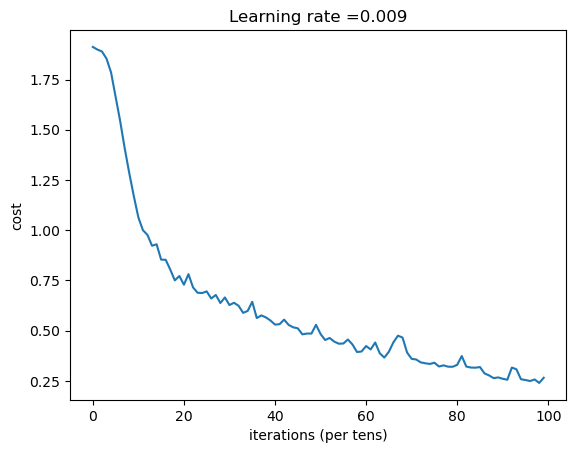

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.91851854
Test Accuracy: 0.8333333


In [16]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

/tmp/ipykernel_20/1773246078.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)


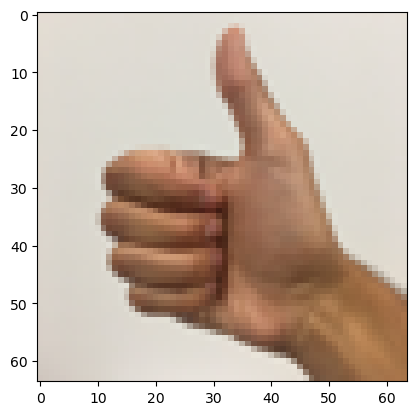

In [17]:
import imageio  # 导入图像IO库
from PIL import Image  # 导入图像处理库

fname = "thumbs_up.jpg"  # 图像文件名
image = imageio.imread(fname)  # 使用imageio库读取图像文件
my_image = np.array(Image.fromarray(image).resize((64, 64)))  # 将图像调整为大小为 64x64 的数组
plt.imshow(my_image)  # 显示图像
plt.show()  # 显示图像